# Setting the Seed for Reproducibility

In [1]:
def set_seed(seed=123):
    import random
    import numpy as np
    import tensorflow as tf
    import warnings
    warnings.filterwarnings("ignore")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

SEED = 123
set_seed(SEED)


# Loading and Splitting the Data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data.drop('Target', axis=1)
    y = data['Target']
    return X, y

def split_data(X, y, test_size=0.3, seed=123):
    return train_test_split(X, y, test_size=test_size, random_state=seed)

file_path = 'merged_bankruptcy_data.csv'
X, y = load_data(file_path)
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.3, seed=SEED)


# Evaluating the Model

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_model(model, X_test, y_test, y_pred, y_pred_prob):
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)

    # Recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("ROC-AUC:", roc_auc)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    # Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_scores = cross_val_score(model, X_test, y_test, cv=cv, scoring='accuracy')
    print("Cross-Validation Scores:", cv_scores)
    print("Mean Cross-Validation Score:", cv_scores.mean())

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='Model (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# Training and Evaluating Function

In [4]:
def train_and_evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)
    
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    evaluate_model(best_model, X_test, y_test, y_pred, y_pred_prob)
    return best_model


# Training and Evaluating a Random Forest Classifier

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Accuracy: 0.999797595433753
Precision: 0.9981308411214953
Recall: 0.9971988795518207
F1 Score: 0.9976646426903316
ROC-AUC: 0.9999982615479052
Confusion Matrix:
 [[23630     2]
 [    3  1068]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23632
           1       1.00      1.00      1.00      1071

    accuracy                           1.00     24703
   macro avg       1.00      1.00      1.00     24703
weighted avg       1.00      1.00      1.00     24703

Cross-Validation Scores: [1.         0.99979761 0.99919045 0.99979757 0.99979757]
Mean Cross-Validation Score: 0.9997166401595508


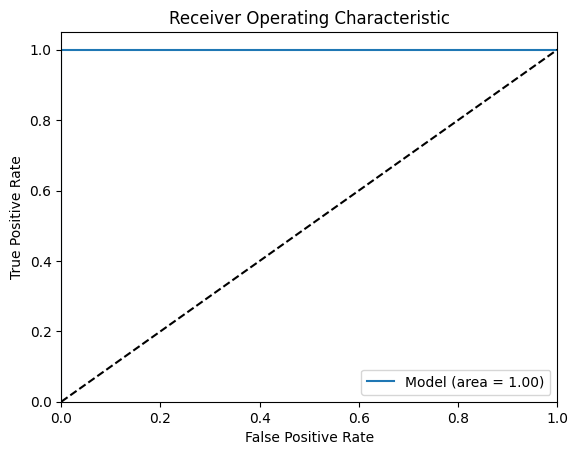

In [5]:
from sklearn.ensemble import RandomForestClassifier

set_seed(SEED)
rf_model = RandomForestClassifier(random_state=SEED)
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}
rf_model = train_and_evaluate_model(rf_model, rf_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Support Vector Machine (SVM) Classifier

Best Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Accuracy: 0.9566449419098895
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.9966983238793148
Confusion Matrix:
 [[23632     0]
 [ 1071     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     23632
           1       0.00      0.00      0.00      1071

    accuracy                           0.96     24703
   macro avg       0.48      0.50      0.49     24703
weighted avg       0.92      0.96      0.94     24703

Cross-Validation Scores: [0.95668893 0.95668893 0.95648654 0.95668016 0.95668016]
Mean Cross-Validation Score: 0.9566449447611369


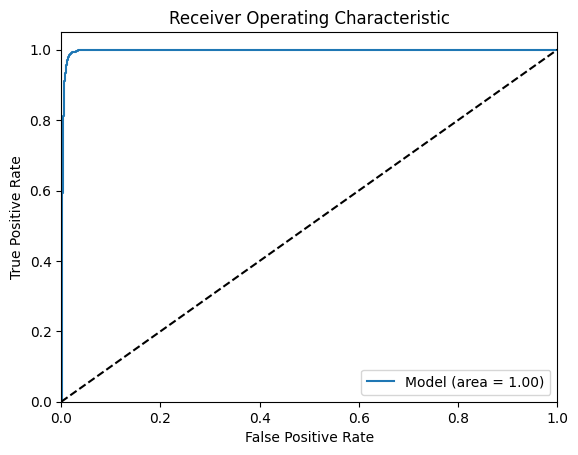

In [6]:
from sklearn.svm import SVC

set_seed(SEED)
svm_model = SVC(probability=True, random_state=SEED)
svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']
}
svm_model = train_and_evaluate_model(svm_model, svm_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Gradient Boosting Classifier

Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Accuracy: 0.9997571145205035
Precision: 0.9962721342031687
Recall: 0.9981325863678805
F1 Score: 0.9972014925373134
ROC-AUC: 0.9999874752428617
Confusion Matrix:
 [[23628     4]
 [    2  1069]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23632
           1       1.00      1.00      1.00      1071

    accuracy                           1.00     24703
   macro avg       1.00      1.00      1.00     24703
weighted avg       1.00      1.00      1.00     24703

Cross-Validation Scores: [0.99979761 0.99979761 0.99939284 0.99979757 0.99939271]
Mean Cross-Validation Score: 0.9996356684996316


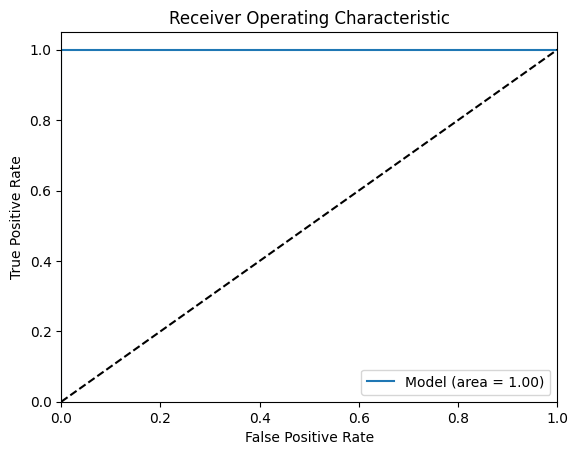

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

set_seed(SEED)
gb_model = GradientBoostingClassifier(random_state=SEED)
gb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
gb_model = train_and_evaluate_model(gb_model, gb_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating an XGBoost Classifier

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Accuracy: 0.9998785572602518
Precision: 0.9972067039106145
Recall: 1.0
F1 Score: 0.9986013986013986
ROC-AUC: 0.9999971157499334
Confusion Matrix:
 [[23629     3]
 [    0  1071]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23632
           1       1.00      1.00      1.00      1071

    accuracy                           1.00     24703
   macro avg       1.00      1.00      1.00     24703
weighted avg       1.00      1.00      1.00     24703

Cross-Validation Scores: [0.99959522 0.99979761 0.99858328 0.99979757 0.99959514]
Mean Cross-Validation Score: 0.9994737661490609


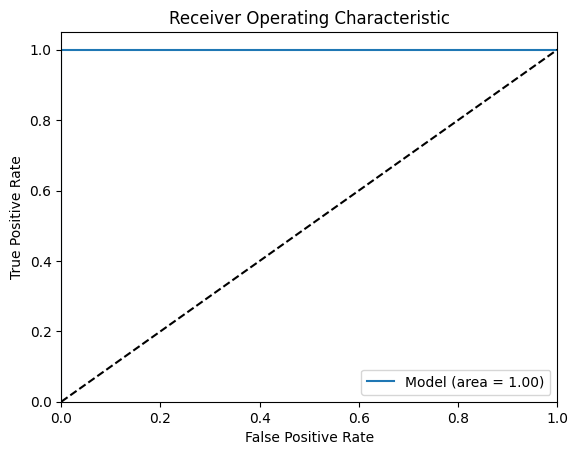

In [8]:
from xgboost import XGBClassifier

set_seed(SEED)
xgb_model = XGBClassifier(random_state=SEED)
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}
xgb_model = train_and_evaluate_model(xgb_model, xgb_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a CatBoost Classifier

Best Parameters: {'classifier__depth': 7, 'classifier__iterations': 200, 'classifier__learning_rate': 0.2}
Accuracy: 0.9997166336072542
Precision: 0.9935064935064936
Recall: 1.0
F1 Score: 0.996742671009772
ROC-AUC: 0.9999993678356018
Confusion Matrix:
 [[23625     7]
 [    0  1071]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23632
           1       0.99      1.00      1.00      1071

    accuracy                           1.00     24703
   macro avg       1.00      1.00      1.00     24703
weighted avg       1.00      1.00      1.00     24703

Cross-Validation Scores: [0.99979761 0.99979761 0.99919045 1.         0.99979757]
Mean Cross-Validation Score: 0.9997166483534041


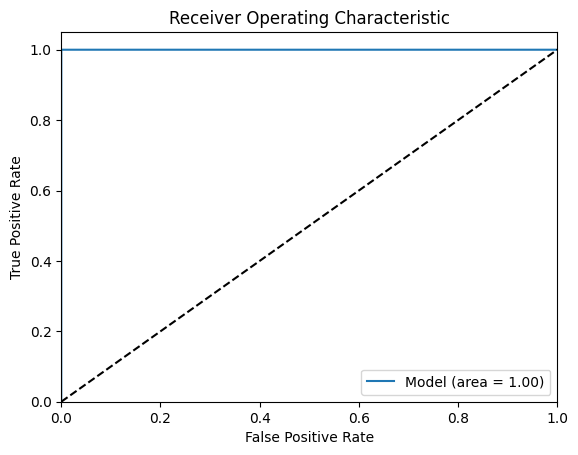

In [9]:
from catboost import CatBoostClassifier

set_seed(SEED)
catboost_model = CatBoostClassifier(random_state=SEED, verbose=0)
catboost_param_grid = {
    'classifier__iterations': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__depth': [3, 5, 7]
}
catboost_model = train_and_evaluate_model(catboost_model, catboost_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a K-Nearest Neighbors (KNN) Classifier

Best Parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}
Accuracy: 0.9991499008217626
Precision: 0.9807692307692307
Recall: 1.0
F1 Score: 0.9902912621359223
ROC-AUC: 0.9998075256959024
Confusion Matrix:
 [[23611    21]
 [    0  1071]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23632
           1       0.98      1.00      0.99      1071

    accuracy                           1.00     24703
   macro avg       0.99      1.00      0.99     24703
weighted avg       1.00      1.00      1.00     24703

Cross-Validation Scores: [0.99919045 0.99898806 0.99797612 0.998583   0.998583  ]
Mean Cross-Validation Score: 0.9986641232945519


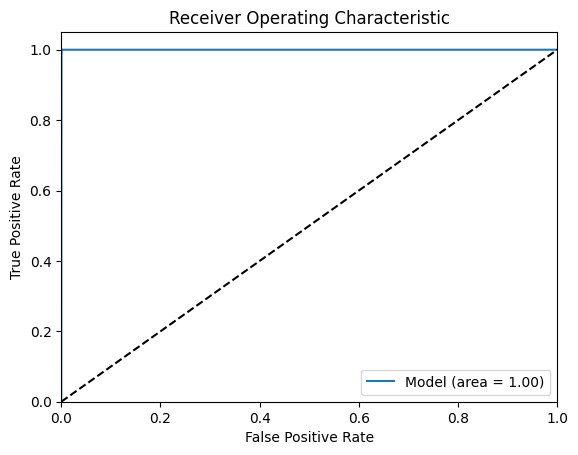

In [10]:
from sklearn.neighbors import KNeighborsClassifier

set_seed(SEED)
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}
knn_model = train_and_evaluate_model(knn_model, knn_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Naive Bayes Classifier

Best Parameters: {'classifier__var_smoothing': 1e-09}
Accuracy: 0.9898392907743999
Precision: 0.8110773899848255
Recall: 0.9981325863678805
F1 Score: 0.8949351192967769
ROC-AUC: 0.9987002304871396
Confusion Matrix:
 [[23383   249]
 [    2  1069]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     23632
           1       0.81      1.00      0.89      1071

    accuracy                           0.99     24703
   macro avg       0.91      0.99      0.94     24703
weighted avg       0.99      0.99      0.99     24703

Cross-Validation Scores: [0.98866626 0.98907104 0.99332119 0.98805668 0.9917004 ]
Mean Cross-Validation Score: 0.9901631150408832


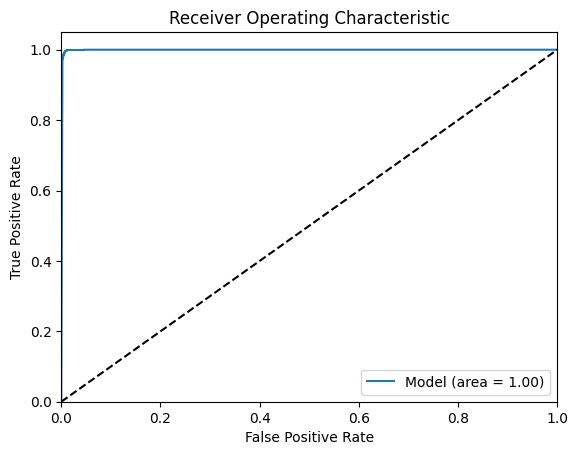

In [11]:
from sklearn.naive_bayes import GaussianNB

set_seed(SEED)
nb_model = GaussianNB()
nb_param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7]
}
nb_model = train_and_evaluate_model(nb_model, nb_param_grid, X_train, X_test, y_train, y_test)


# Training and Evaluating a Logistic Regression Classifier

Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Accuracy: 0.9566449419098895
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.9849361545566094
Confusion Matrix:
 [[23632     0]
 [ 1071     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     23632
           1       0.00      0.00      0.00      1071

    accuracy                           0.96     24703
   macro avg       0.48      0.50      0.49     24703
weighted avg       0.92      0.96      0.94     24703

Cross-Validation Scores: [0.95668893 0.95668893 0.95648654 0.95668016 0.95668016]
Mean Cross-Validation Score: 0.9566449447611369


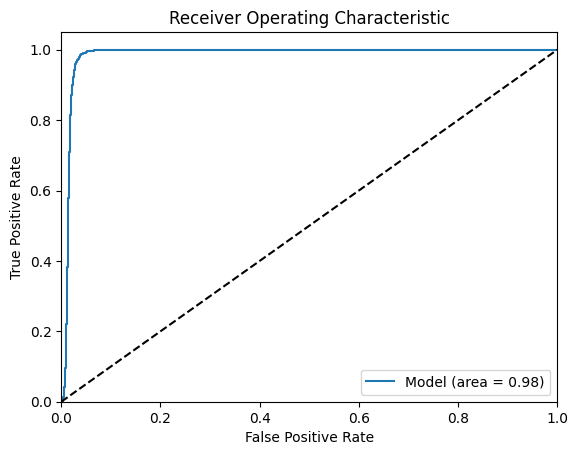

In [12]:
from sklearn.linear_model import LogisticRegression

set_seed(SEED)
lr_model = LogisticRegression(random_state=SEED, max_iter=10000)
lr_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga']
}
lr_model = train_and_evaluate_model(lr_model, lr_param_grid, X_train, X_test, y_train, y_test)


# Making Predictions on New Data

In [13]:
def predict_new_data(model, new_data):
    new_predictions = model.predict(new_data)
    print("Predictions for new data:", new_predictions)
    return new_predictions

new_data = pd.DataFrame({
    'Current Assets': [233.211, 105.559, 63.971, 135.207, 82.589, 1.2164, 1.0049, 0.72926, 0.80974, 0.83593, 0.68673],
    'Net Income': [25.261, 129.688, -1.442, -20.401, -50.946, 1.281, 1.27, 1.0529, 1.1131, 1.0623, 1.0558],
    'EBIT': [31.521, 159.541, 13.994, 3.841, 2.061, 0.5251, 0.62288, 0.43292, 0.67546, 0.742, 0.77198],
    'Retained Earnings': [28.095, 157.783, 156.341, 135.941, 84.995, 0.18827, 0.18104, 0.044865, 0.091033, 0.0478, 0.043102],
    'Total Liabilities': [225.887, 880.327, 770.233, 776.697, 712.687, 0.022934, 0.0064542, -0.059379, -0.015229, 0.10702, 0.081916]
})

predict_new_data(rf_model, new_data)
predict_new_data(svm_model, new_data)
predict_new_data(gb_model, new_data)
predict_new_data(xgb_model, new_data)
predict_new_data(catboost_model, new_data)
predict_new_data(knn_model, new_data)
predict_new_data(nb_model, new_data)
predict_new_data(lr_model, new_data)


Predictions for new data: [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data: [0 0 0 0 0 0 0 0 0 0 0]
Predictions for new data: [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data: [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data: [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data: [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data: [0 0 0 0 0 1 1 1 1 1 1]
Predictions for new data: [0 0 0 0 0 0 0 0 0 0 0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)